In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

DOWNLOAD THE DATASET WITH API

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:07<00:00, 20.8MB/s]
100% 149M/149M [00:07<00:00, 21.4MB/s]


In [5]:
!unzip -qq brain-tumor-mri-dataset.zip

LIBRARIES AND PREPROCESSING

In [6]:
import os
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
#FOR NN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax

print ('modules loaded')

modules loaded


PREPROCESSING

In [7]:
train_path = "/content/Training"
labels=[]
filepaths=[]
folds = os.listdir(train_path)
for fold in folds:
  foldpath=os.path.join(train_path,fold)
  foldlist=os.listdir(foldpath)
  for file in foldlist:
    filepath=os.path.join(foldpath,file)
    labels.append(fold)
    filepaths.append(filepath)

  l=pd.Series(labels,name="labels")
  f=pd.Series(filepaths,name="filepaths")
  tr_df = pd.concat([f,l],axis=1)

In [8]:
tr_df

filepaths      labels
0         /content/Training/glioma/Tr-gl_0497.jpg      glioma
1         /content/Training/glioma/Tr-gl_0048.jpg      glioma
2         /content/Training/glioma/Tr-gl_1228.jpg      glioma
3         /content/Training/glioma/Tr-gl_0659.jpg      glioma
4         /content/Training/glioma/Tr-gl_0268.jpg      glioma
...                                           ...         ...
5707  /content/Training/meningioma/Tr-me_0050.jpg  meningioma
5708  /content/Training/meningioma/Tr-me_0460.jpg  meningioma
5709  /content/Training/meningioma/Tr-me_0023.jpg  meningioma
5710  /content/Training/meningioma/Tr-me_0708.jpg  meningioma
5711  /content/Training/meningioma/Tr-me_1045.jpg  meningioma

[5712 rows x 2 columns]

In [9]:
test_path = "/content/Testing"
labels=[]
filepaths=[]
folds = os.listdir(test_path)
for fold in folds:
  foldpath=os.path.join(test_path,fold)
  foldlist=os.listdir(foldpath)
  for file in foldlist:
    filepath=os.path.join(foldpath,file)
    labels.append(fold)
    filepaths.append(filepath)

  l=pd.Series(labels,name="labels")
  f=pd.Series(filepaths,name="filepaths")
  ts_df = pd.concat([f,l],axis=1)

In [10]:
ts_df

filepaths      labels
0         /content/Testing/glioma/Te-gl_0286.jpg      glioma
1         /content/Testing/glioma/Te-gl_0090.jpg      glioma
2         /content/Testing/glioma/Te-gl_0226.jpg      glioma
3         /content/Testing/glioma/Te-gl_0218.jpg      glioma
4         /content/Testing/glioma/Te-gl_0181.jpg      glioma
...                                          ...         ...
1306  /content/Testing/meningioma/Te-me_0047.jpg  meningioma
1307  /content/Testing/meningioma/Te-me_0230.jpg  meningioma
1308  /content/Testing/meningioma/Te-me_0274.jpg  meningioma
1309  /content/Testing/meningioma/Te-me_0294.jpg  meningioma
1310  /content/Testing/meningioma/Te-me_0212.jpg  meningioma

[1311 rows x 2 columns]

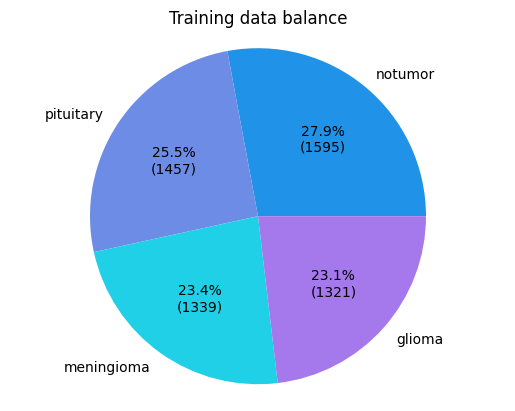

labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [11]:
data_balance = tr_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct,
        colors = ["#2092E8","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()
data_balance

In [12]:
valid_df,tst_df=train_test_split(ts_df,test_size=0.5,random_state=50,stratify=ts_df["labels"])
print(f"ts_df shape: {ts_df.shape}")
print("---"*10)
print(f"valid data shape: {valid_df.shape}")
print(f"test data shape: {tst_df.shape}")

ts_df shape: (1311, 2)
------------------------------
valid data shape: (655, 2)
test data shape: (656, 2)


In [13]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(tr_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


valid_gen=ts.flow_from_dataframe(ts_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


test_gen=ts.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


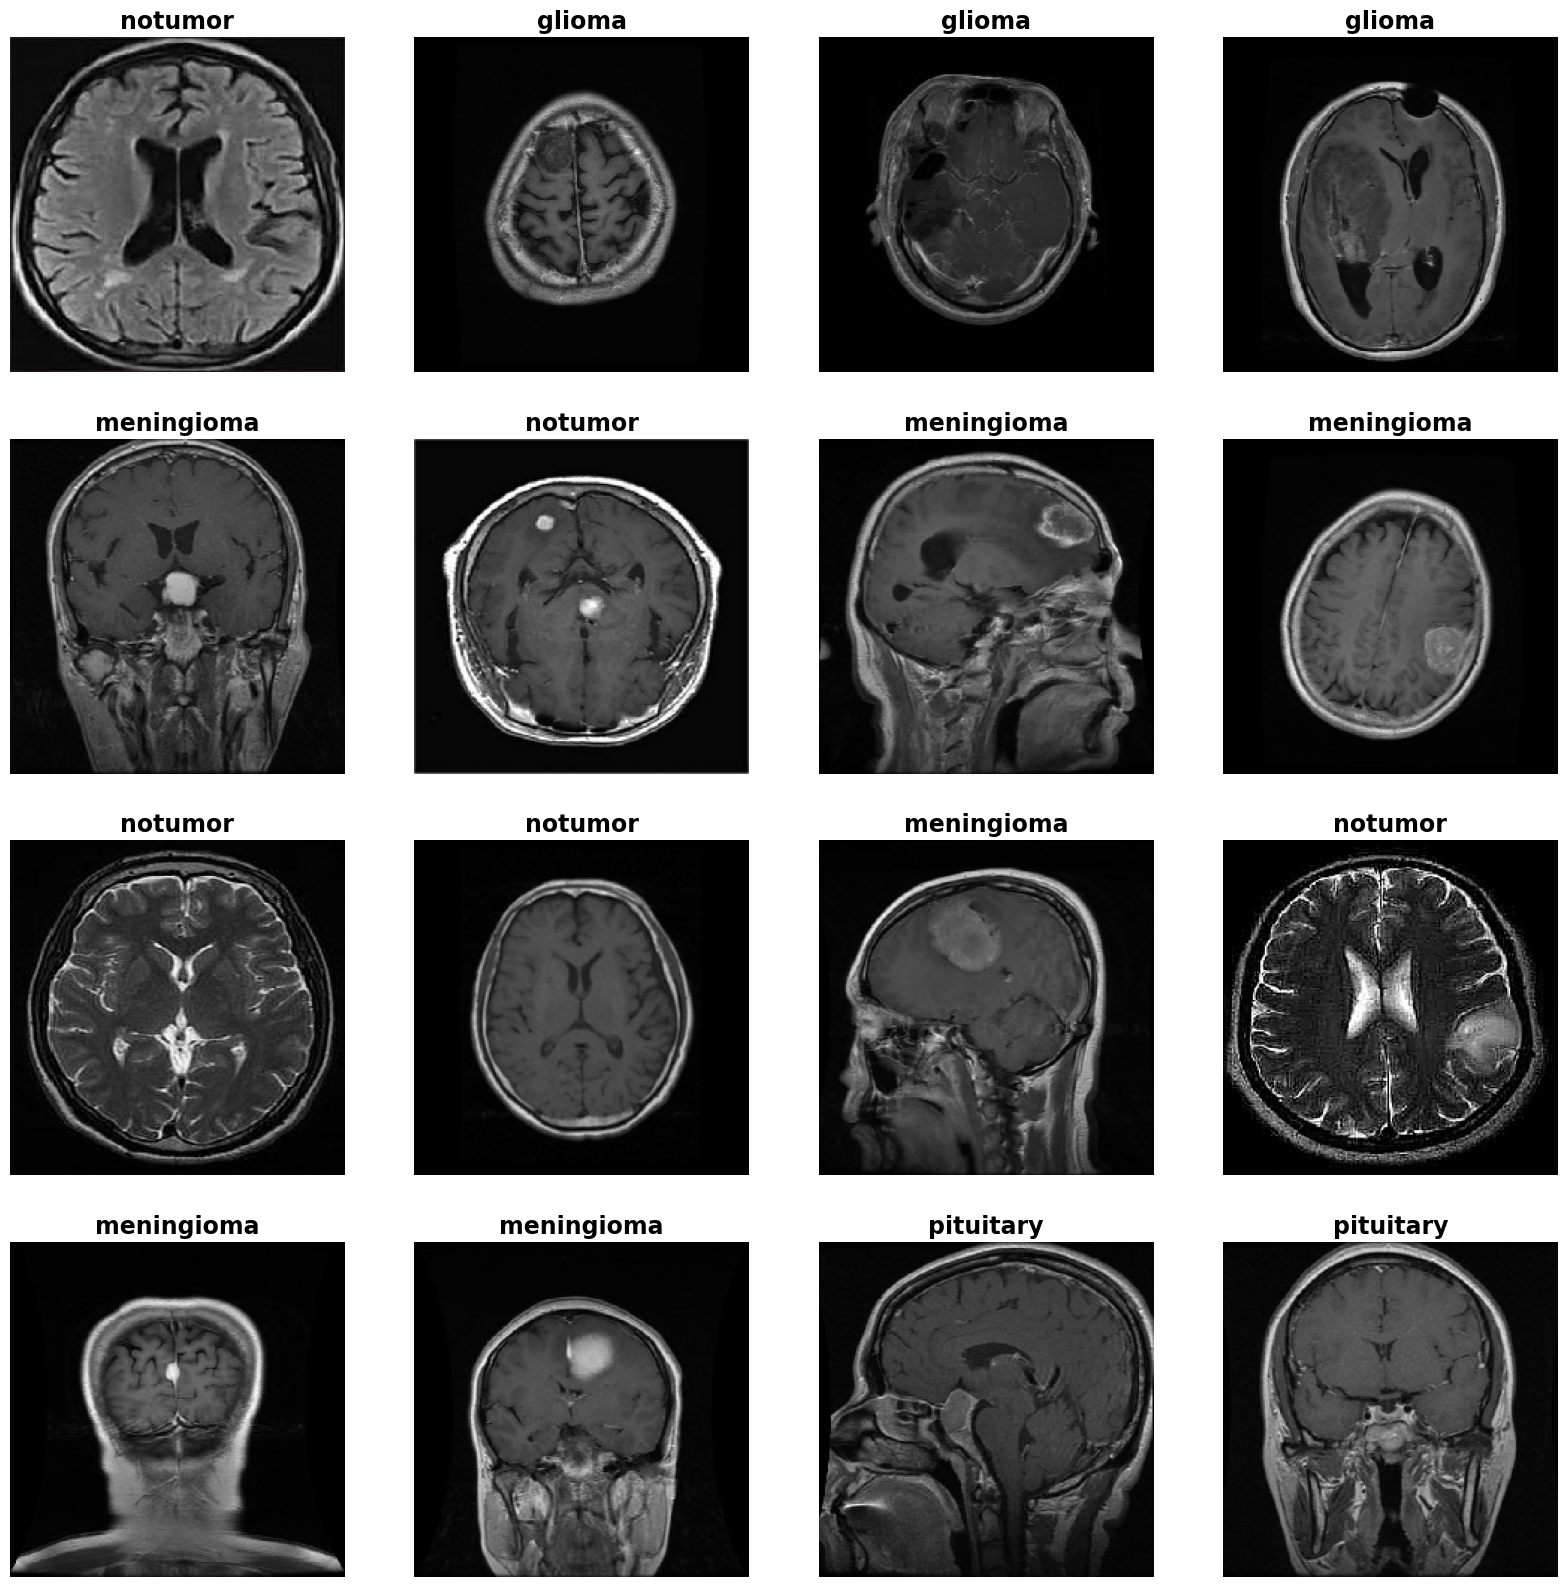

In [14]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

In [15]:
img_shape=(224,224,3)
base_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

Model = Sequential([
    base_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

Model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


ValueError: Undefined shapes are not supported.

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

img_shape = (224, 224, 3)

# Define the input layer
input_layer = Input(shape=img_shape)

# Load the base model (Xception) without the top layer
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                            input_tensor=input_layer, pooling='max')

# Add custom layers on top of the base model
x = Dropout(rate=0.5)(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_layer = Dense(4, activation='softmax')(x)

# Create the model
Model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
Model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
Model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [20]:
tf.keras.utils.plot_model(Model,show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.763408 to fit



In [21]:
historyy=Model.fit(train_gen,epochs=10,
                  validation_data=valid_gen,
                  shuffle=False)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 143s 260ms/step - accuracy: 0.7823 - loss: 0.5917 - val_accuracy: 0.8818 - val_loss: 0.4283
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9639 - loss: 0.1170 - val_accuracy: 0.9641 - val_loss: 0.3489
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 239ms/step - accuracy: 0.9874 - loss: 0.0444 - val_accuracy: 0.9519 - val_loss: 0.2254
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 239ms/step - accuracy: 0.9922 - loss: 0.0328 - val_accuracy: 0.9634 - val_loss: 0.1051
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 239ms/step - accuracy: 0.9925 - loss: 0.0249 - val_accuracy: 0.9855 - val_loss: 0.0465
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9923 - loss: 0.0293 - val_accuracy: 0.9901 - val_loss: 0.0423
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 239ms/step - accuracy: 0.9976 - loss: 0.0119 - val_accuracy: 0.9924 - val_loss: 0.0445
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 90s 253ms/step - accuracy: 0.9963 - loss: 0.0123 - va

In [23]:
model_json = Model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
Model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
historyy.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

<Figure size 2000x800 with 0 Axes>

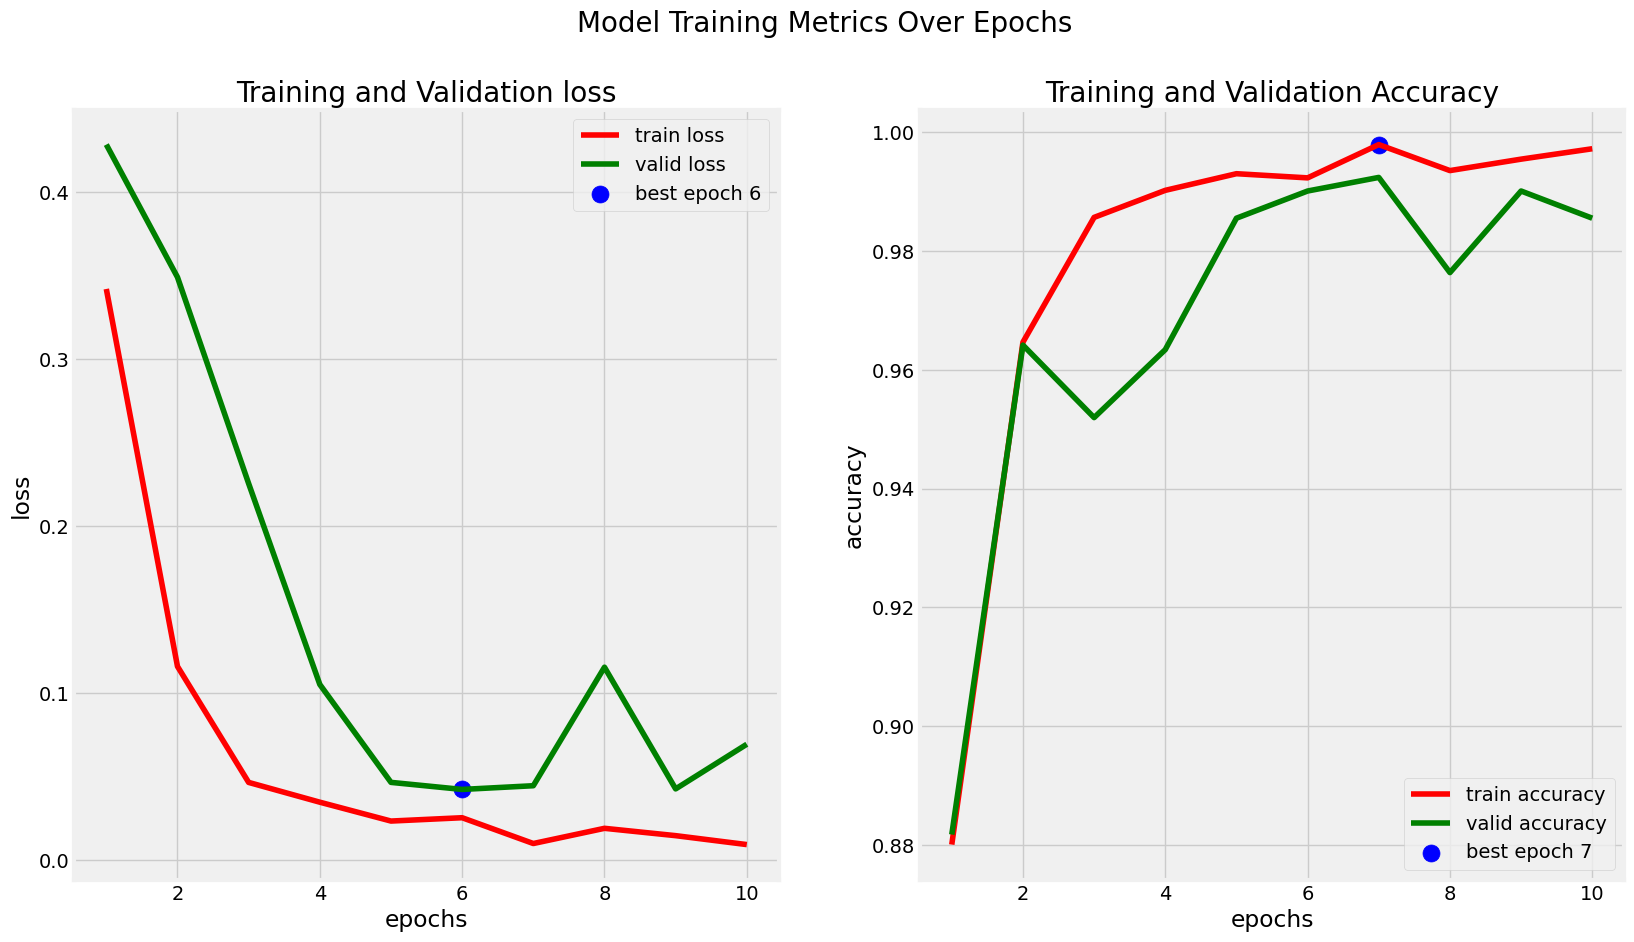

In [25]:
plt.figure(figsize=(20, 8))
tr_loss=historyy.history["loss"]
val_loss=historyy.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=historyy.history["accuracy"]
val_accuracy=historyy.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

In [26]:
train_score=Model.evaluate(train_gen)
valid_score=Model.evaluate(valid_gen)
test_score=Model.evaluate(test_gen)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.9973 - loss: 0.0077
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9859 - loss: 0.0615
 2/82 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 1.5534e-06  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9933 - loss: 0.0388
Train Loss : 0.005
Train Accuracy : 99.81%
--------------------
Validation Loss : 0.069
Validation Accuracy : 98.55%
--------------------
Test Loss: 0.069
Test Accuracy: 98.55%


In [27]:
preds=Model.predict(test_gen)
y_pred=np.argmax(preds,axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step


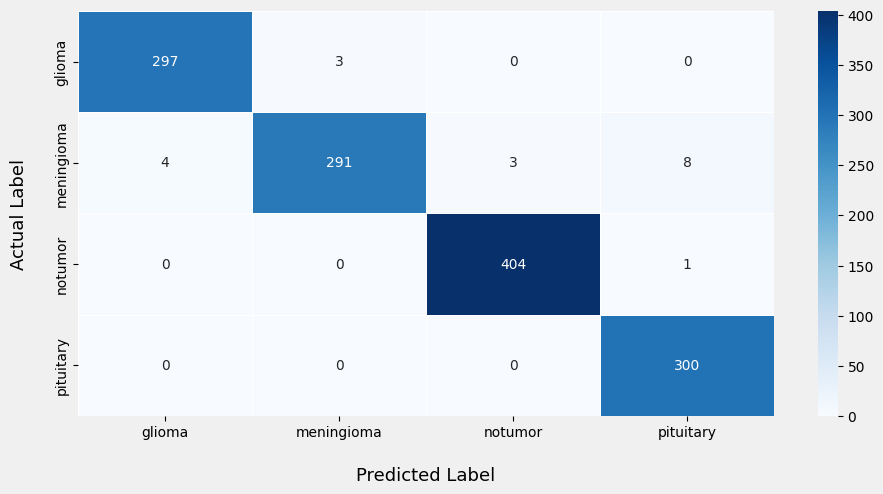

In [28]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [29]:
cr=classification_report(test_gen.classes,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.99      0.95      0.97       306
           2       0.99      1.00      1.00       405
           3       0.97      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



In [31]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 32.2 MB/s eta 0:00:00


In [32]:
import json

import numpy as np
import torch
import torchvision

import shap

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
!ls -l model.h5

ls: cannot access 'model.h5': No such file or directory


In [35]:
!file model.h5

model.h5: cannot open `model.h5' (No such file or directory)


In [36]:
Model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 63,263,750 (241.33 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,139,482 (160.75 MB)